In [192]:
# Binary Classification 
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from keras.optimizers import RMSprop,Adam
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils

from visual_callbacks import AccLossPlotter,  ConfusionMatrixPlotter
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NeighbourhoodCleaningRule, OneSidedSelection

In [193]:
#plot confisuon matrix metodu
def plot_confusion_matrix(cm, names,normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [194]:
# load dataset
dataframe = pd.read_csv("KidneyStoneDataset.csv", header=None)
dataset = dataframe.values
# split into input (X) and output (Y) variables
X = dataset[:,0:5120]
Y = dataset[:,5120]
#verileri normalize etmesem de sonuç değişmiyor
normalized_X = preprocessing.normalize(X) 

In [195]:
print(normalized_X)
print(Y)

[[7.13e-04 1.07e-03 1.19e-03 ... 1.45e-02 1.60e-02 1.27e-02]
 [7.80e-04 7.80e-04 7.80e-04 ... 1.34e-03 5.57e-04 2.23e-04]
 [4.57e-04 3.48e-03 9.69e-03 ... 9.15e-05 9.15e-05 0.00e+00]
 ...
 [1.10e-02 1.14e-02 1.61e-02 ... 6.32e-03 6.65e-03 8.60e-03]
 [3.76e-03 4.77e-03 5.21e-03 ... 7.67e-03 6.37e-03 5.35e-03]
 [1.16e-02 4.15e-03 2.08e-03 ... 1.77e-02 1.78e-02 1.80e-02]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [196]:
len(X)

221

Verisetinde 221 adet veri bulunmaktadır. Bunlardan 39 tanesi sağlıklı (0 etiketi), 182 tanesi ise hasta (1 etiketi) olarak belirlenmiştir.

In [204]:
X = np.array(normalized_X) 
y = np.array(Y)

In [205]:
#undersampling-oversampling işlemleri
#over = SMOTE(sampling_strategy=0.3)
#under = RandomUnderSampler(sampling_strategy=0.6)
over=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))

In [206]:
#gridsearch for decision tree
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    #for decision tree
    #param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)} 
    
    #for RANDOM FOREST
    #param_grid = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 
    #              'max_depth': [4, 5, 6, 7, 8], 'criterion': ['gini', 'entropy']}
    
    
    #FOR SVC
    #param_grid = {'C': [0.1, 1, 10, 100, 1000],  
    #          'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
     #        'kernel': ['rbf']}  
    
    #FOR MLPClassifier
    #param_grid={'solver': ['sgd','adam','lbfgs'],'max_iter': [300,500,700,1000],
    #'alpha': [0.0001, 0.05],
    #'learning_rate': ['constant','adaptive']}
 
    #knn
    #param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
     #                                    13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
      #                                   23, 24, 25, 26, 27, 28, 29, 30]}
   #bayes
    #param_grid = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
     #    }
   # decision tree model
   # dtree_model=DecisionTreeClassifier()
    #dtree_model=RandomForestClassifier()
    #dtree_model=svm.SVC()
    #dtree_model=MLPClassifier()
    #dtree_model=KNeighborsClassifier()
    #dtree_model=BernoulliNB()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

In [207]:
#print(dtree_grid_search(X,y,5))

In [208]:
#kullanılan algoritmalar ve cv yöntemi
model=DecisionTreeClassifier(criterion='gini',max_depth=3)
#model=RandomForestClassifier(criterion= 'entropy', max_depth= 4, max_features= 'log2', n_estimators= 200)
#model=svm.SVC(C=0.1, gamma=1, kernel='rbf')
#model=MLPClassifier(random_state=1, max_iter=300)
#model=KNeighborsClassifier(n_neighbors= 16)
#model=BernoulliNB(alpha= 10.0)
steps = [ ('o',over),('m', model)] 
pipeline = Pipeline(steps=steps)
# evaluate pipeline
n_splits=5
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=100)
cv = StratifiedKFold(n_splits=n_splits,random_state=None,shuffle=True)

In [209]:
#Cross validation ile Precision, recall ve f1 score değerlerinin hesaplanması
acc = cross_val_score(pipeline, X, y, scoring='precision', cv=cv, n_jobs=-1)
acc = mean(acc)
print('Precision: %.3f' % acc)
recall = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
acc = mean(acc)
print('Recall: %.3f' % acc)
scores = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)
score = mean(scores)
print('F1 Score: %.3f' % score)

Precision: 0.820
Recall: 0.820
F1 Score: 0.773


Precision: 0.808
Recall: 0.692
F1 Score: 0.746
Confusion matrix
[[  9  30]
 [ 56 126]]


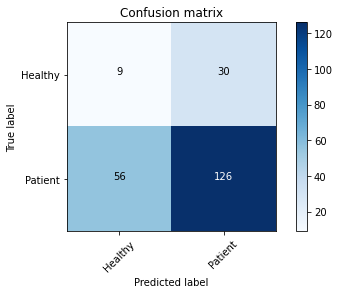

In [210]:
#oversampling ve Decision Tree yöntemi sonucu oluşan cross_val_predict confisuon matrix
y_pred = cross_val_predict(pipeline, X, y, cv=cv)
precision = precision_score(y, y_pred)
print('Precision: %.3f' % precision)
recall = recall_score(y, y_pred)
print('Recall: %.3f' % recall)
f1=f1_score(y,y_pred)
print('F1 Score: %.3f' % f1)


cm = confusion_matrix(y, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure()
class_names = ['Healthy', 'Patient']
plot_confusion_matrix(cm, class_names)